# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average (cloud-free) pixel values.

#### Initialize

In [1]:
import ee
ee.Initialize()

In [2]:
import os
import sys
import numpy as np
from matplotlib import pylab as plt
import pandas as pd
%matplotlib inline
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))

from ee_requests import request_meanRadiance
from atmcorr_timeseries import surface_reflectance_timeseries
from plots import plot_timeseries
from IPython.display import display, Image

### User Input

In [3]:
# region of interest
geom = ee.Geometry.Point(-122.2586, 37.4967)

# start and end of time series
startDate = ee.Date('1980-01-01')# YYYY-MM-DD
stopDate  = ee.Date('2020-01-01')# YYYY-MM-DD

# satellite mission
mission = 'Sentinel2' # options = 'Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4'

# cloud and cloud shadow mask?
removeClouds = True

#### Interpolated look-up tables

The emulator uses interpolated look-up tables to generate atmospheric correction coeffients.

In [4]:
import interpolated_lookup_tables as iLUT

iLUTs = iLUT.handler(mission) 
iLUTs.get()

Loading interpolated look up tables (.ilut)..
Interpolated look-up table files not found in:
/home/sam/github/ee-atmcorr-timeseries/files/iLUTs/S2A_MSI/Continental/view_zenith_0
downloading look up table (.lut) files..
download successful

...Running n-dimensional interpolation may take a several minutes (only need to do this once)...
Interpolating: S2A_MSI_01.lut
Interpolation took 64.23 (secs) = 
Interpolating: S2A_MSI_02.lut
Interpolation took 65.10 (secs) = 
Interpolating: S2A_MSI_03.lut
Interpolation took 65.69 (secs) = 
Interpolating: S2A_MSI_04.lut
Interpolation took 64.31 (secs) = 
Interpolating: S2A_MSI_05.lut
Interpolation took 63.88 (secs) = 
Interpolating: S2A_MSI_06.lut
Interpolation took 64.06 (secs) = 
Interpolating: S2A_MSI_07.lut
Interpolation took 64.08 (secs) = 
Interpolating: S2A_MSI_08.lut
Interpolation took 63.37 (secs) = 
Interpolating: S2A_MSI_09.lut
Interpolation took 63.18 (secs) = 
Interpolating: S2A_MSI_10.lut
Interpolation took 63.10 (secs) = 
Interpolating

#### Mean Average Radiance

In [5]:
# earth engine request
request = request_meanRadiance(geom, startDate, stopDate, mission, removeClouds)

In [6]:
# get data locally (i.e. client side)
print('Getting data from Earth Engine.. ')
meanRadiance = request.getInfo()
print('Data collection complete')

Getting data from Earth Engine.. 
Data collection complete


#### Two or more images?

In [7]:
num = len(meanRadiance['features'])
print('length of data collection = ',num)
if num < 2:
    print('*'*42+'\nneed at least 2 images, try user inputs?\n'+'*'*42)

length of data collection =  61


#### Atmospheric Correction

In [8]:
timeSeries = surface_reflectance_timeseries(meanRadiance, iLUTs, mission)

### Plots

#### Visible wavelengths

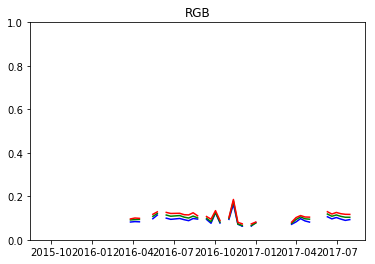

In [9]:
plot_timeseries(timeSeries, 'visible')

#### Near infrared

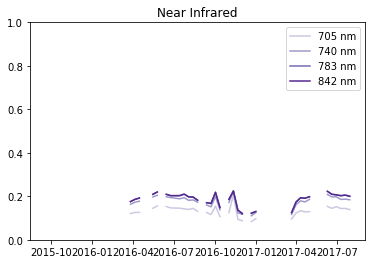

In [10]:
plot_timeseries(timeSeries, 'nir')

#### Short-wave Infrared

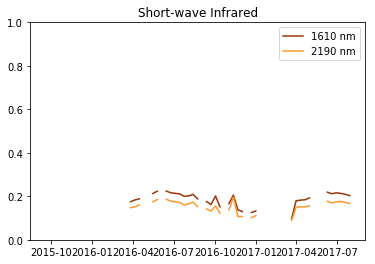

In [11]:
plot_timeseries(timeSeries, 'swir')

#### Atmospheric bands

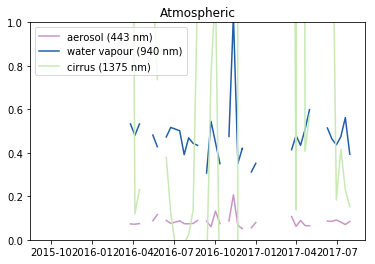

In [12]:
atmcorr_bands_exist = plot_timeseries(timeSeries, 'atmospheric')
if not atmcorr_bands_exist:
    print('atmospheric bands not available for:',timeSeries['mission'])

#### Save to excel

In [13]:
# create an excel directory
excel_dir = os.path.join(base_dir,'files','excel')
if not os.path.exists(excel_dir):
    os.makedirs(excel_dir)

# create pandas data frame
df = pd.DataFrame.from_dict(timeSeries)

# save to excel
df.to_excel(os.path.join(excel_dir, mission+'.xlsx'), index=False)